In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
from tqdm.autonotebook import tqdm
tqdm.pandas(desc='Progress bar', leave=False)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier  
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from yellowbrick.target import ClassBalance
from yellowbrick.target import BalancedBinningReference
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.contrib.classifier import DecisionViz
from mlxtend.plotting import plot_decision_regions


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':100})

<ipython-input-1-6ba959c0940e>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Random seed

In [2]:
seed = 123

## Read in the datasets

In [3]:

file_path = r's3://osanusi-auto/capstone-preprocessed-data.csv'
df = pd.read_csv(file_path)
df.head()

,domain,title,authors,content,c_word_count,t_word_count,c_character_count,t_character_count,c_avg_word_length,t_avg_word_length,sentiment,label
0,nytimes,candidate,bernard gwertzman,person astonishingly frank selfportrait russia...,423,1,2696,9,6.373522,9.000000,neutral,real
1,nytimes,white house set deadline forest rule,douglas jehl,prodding federal judge bush administration sai...,125,6,834,31,6.672000,5.166667,neutral,real
2,nytimes,aerosmith relishing incarnation,ann powers,twentyfive year ago aerosmith headliner saturd...,188,3,1208,29,6.425532,9.666667,neutral,real
3,nytimes,college graduate year hoping chance throe reality,marc zawel,worstcase scenario newly minted college grad s...,288,7,1847,43,6.413194,6.142857,neutral,real
4,nytimes,rolled hand large small,elaine louie,night family member pitch dinner idea vote get...,257,4,1435,20,5.583658,5.000000,negative,real


In [4]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [5]:
missing_value(df)

,Total,Percent
title,6247,0.572892
authors,2358,0.216245
content,1,0.000092
label,0,0.000000
sentiment,0,0.000000
t_avg_word_length,0,0.000000
c_avg_word_length,0,0.000000
t_character_count,0,0.000000
c_character_count,0,0.000000
t_word_count,0,0.000000


In [6]:
df.dropna(inplace=True)
missing_value(df)

,Total,Percent
label,0,0.0
sentiment,0,0.0
t_avg_word_length,0,0.0
c_avg_word_length,0,0.0
t_character_count,0,0.0
c_character_count,0,0.0
t_word_count,0,0.0
c_word_count,0,0.0
content,0,0.0
authors,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081829 entries, 0 to 1090431
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   domain             1081829 non-null  object 
 1   title              1081829 non-null  object 
 2   authors            1081829 non-null  object 
 3   content            1081829 non-null  object 
 4   c_word_count       1081829 non-null  int64  
 5   t_word_count       1081829 non-null  int64  
 6   c_character_count  1081829 non-null  int64  
 7   t_character_count  1081829 non-null  int64  
 8   c_avg_word_length  1081829 non-null  float64
 9   t_avg_word_length  1081829 non-null  float64
 10  sentiment          1081829 non-null  object 
 11  label              1081829 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 107.3+ MB


## Feature engineering and vectorization

The data contains heterogeneous data types, there are  numerical, categorical  and text data. Different vectorization method was used to transform the data in those different columns.

 `one-hot encoding` for all categorical features, `robustscaler` for numeric  and `tfidfvectorizer` for the text features.

`ColumnTransformer` was used to combine all those transformations.

In [8]:
#Convert `domain` to category data type.
df['domain'] = df['domain'].astype('category')

## Features and target variables

In [9]:
target = df.label
features = df[['domain', 'content', 'title','authors','c_word_count','t_word_count','c_avg_word_length','t_avg_word_length','sentiment']].copy()

## Split the data in training and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=seed)
print(df.shape); print(X_train.shape); print(X_test.shape)

(1081829, 12)
(865463, 9)
(216366, 9)


## Checking the distribution of classes in the target

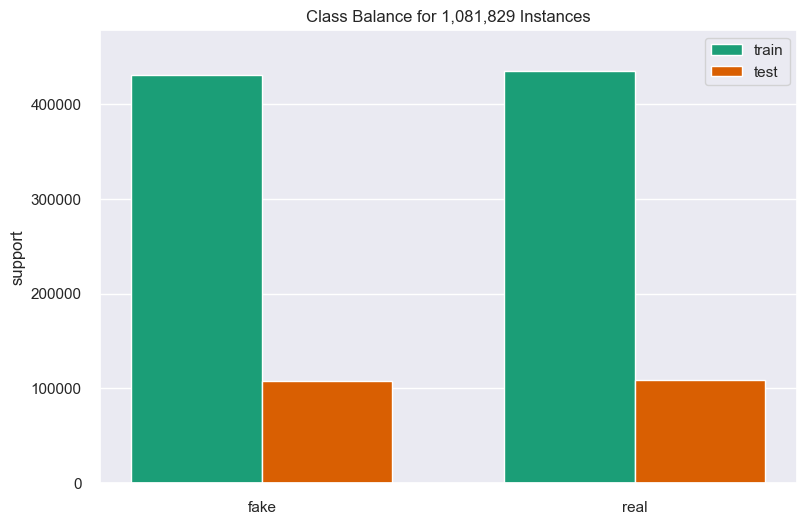

In [11]:
viz = ClassBalance(labels=['fake','real'])
viz.fit(y_train, y_test)
viz.show();

## Applying ColumnTransformer

In [12]:
# defining the numerical, categorical and textual features
numerical = ['c_word_count','c_avg_word_length','t_word_count','t_avg_word_length']
categorical = ['domain','authors','sentiment']
textual = ['title','content']

In [13]:
#Important:  pass the columns as string to CountVectorizer/TfifVectorizer and list of columns (even list of one column) to 
# OneHotEncoding (OHE) to make it work
ct = ColumnTransformer(
    [('num', MinMaxScaler(), numerical),
     ('sentiment', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['sentiment']),
     ('domain', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['domain']),
     ('authors', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['authors']),
     ('title', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'title'),
     ('content', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'content')], n_jobs=3, verbose=True)

## View the diagram of the column transformer

In [14]:
set_config(display='diagram')
ct

ColumnTransformer(n_jobs=3,
                  transformers=[('num', MinMaxScaler(),
                                 ['c_word_count', 'c_avg_word_length',
                                  't_word_count', 't_avg_word_length']),
                                ('sentiment',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['sentiment']),
                                ('domain',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['domain']),
                                ('authors',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['authors']),
                                ('title',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'title'),
                                ('content',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'content')],
                  verbose=True)

## Tranform the features into vectors

In [15]:
%%time
# Creating the feature matrix
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
print(f'Shape of Term Frequency Matrix of train: {X_train.shape}')
print(f'Shape of Term Frequency Matrix of test: {X_test.shape}')

Shape of Term Frequency Matrix of train: (865463, 71042)
Shape of Term Frequency Matrix of test: (216366, 71042)
Wall time: 5min 20s


## Encode the target

In [16]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)
print(y_train.shape); print(y_test.shape)

(865463,)
(216366,)


## The encoded classes in the target

In [17]:
classes = Encoder.classes_
classes

array(['fake', 'real'], dtype=object)

## Models training

## Instantiate and train the models

In [18]:
# Logistics regression
logreg = LogisticRegression(random_state=seed)

# Training the model 
logreg.fit(X_train, y_train) 


LogisticRegression(random_state=123)

In [19]:
# Decision tree classifier
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth= 20, splitter='best', random_state=seed)
# Training the model 
dtc.fit(X_train, y_train) 


DecisionTreeClassifier(max_depth=20, random_state=123)

In [20]:
# Linear SVC
lsvc = LinearSVC(C=0.01, dual=False, random_state=seed)
# Training the model 
lsvc.fit(X_train, y_train) 


LinearSVC(C=0.01, dual=False, random_state=123)

In [21]:
# RandomForest classifier
rfc = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=seed, n_jobs=-1)
# Training the model 
rfc.fit(X_train, y_train) 


RandomForestClassifier(n_jobs=-1, random_state=123)

In [22]:
# SGDClassifier
sgdc = SGDClassifier(max_iter=1500,random_state=seed)
# Training the model 
sgdc.fit(X_train, y_train) 


SGDClassifier(max_iter=1500, random_state=123)

In [23]:
# MultinomialNB
mnb = MultinomialNB()
# Training the model 
mnb.fit(X_train, y_train) 


MultinomialNB()

## Predict with the trained models

In [24]:
#Predict the Test using the logistics regression
y_pred_lr = logreg.predict(X_test)

In [25]:
#Predict the Test using decision tree 
y_pred_dtc = dtc.predict(X_test)

In [26]:
#Predict the Test using linear svc
y_pred_lsvc = lsvc.predict(X_test)

In [27]:
#Predict the Test using RandomForest classifier
y_pred_rfc = rfc.predict(X_test)

In [28]:
#Predict the Test using SGDClassifier
y_pred_sgdc = sgdc.predict(X_test)

In [29]:
#Predict the Test using MultinomialNB
y_pred_mnb = mnb.predict(X_test)

## Evaluate the fitted models

### Confusion matrix

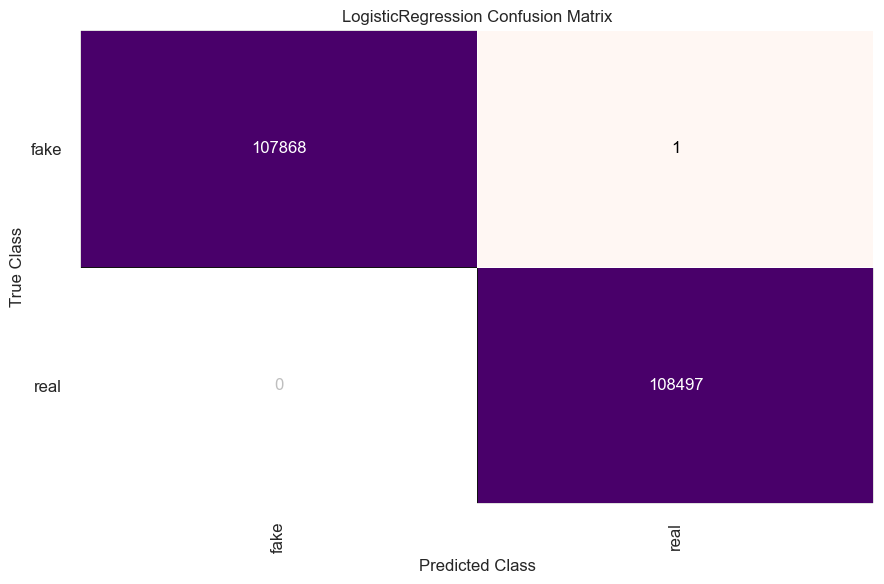

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [30]:
cm = ConfusionMatrix(logreg, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

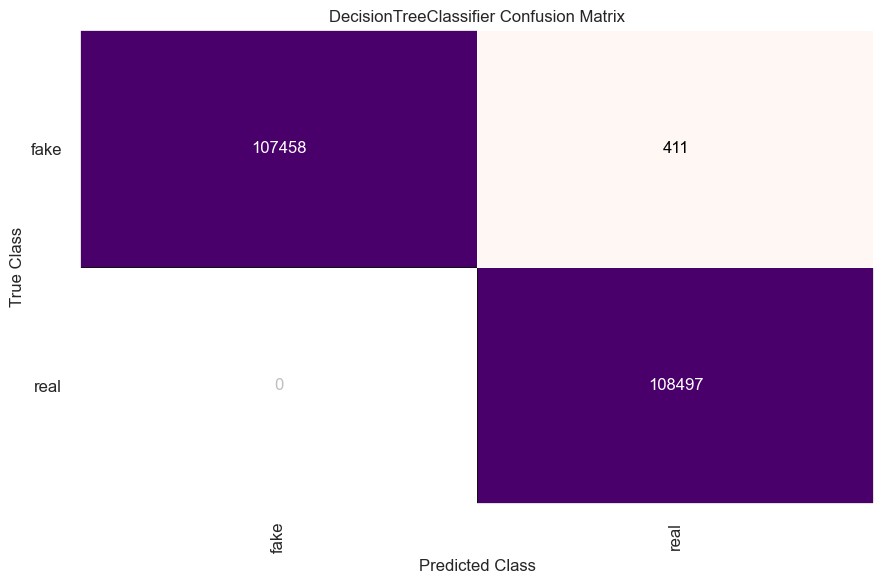

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [31]:
cm = ConfusionMatrix(dtc, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

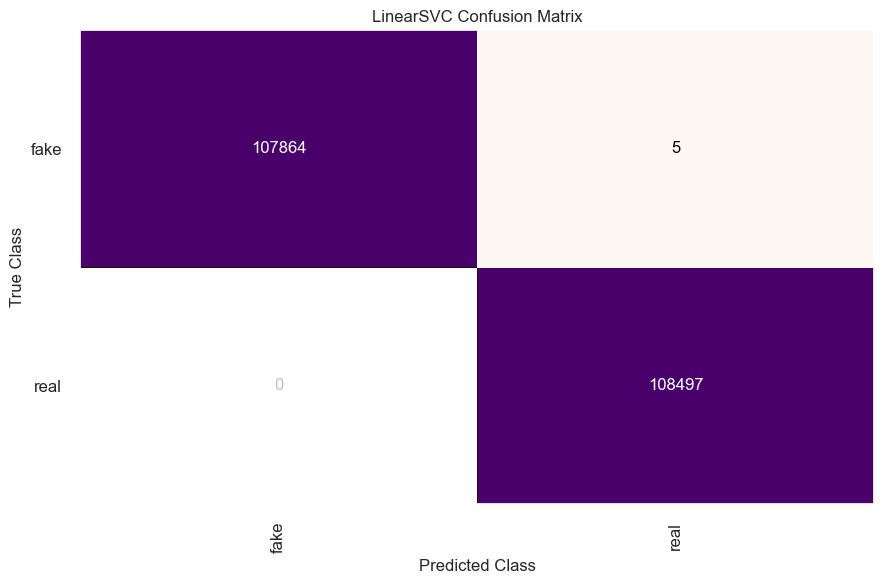

<AxesSubplot:title={'center':'LinearSVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [32]:
cm = ConfusionMatrix(lsvc, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

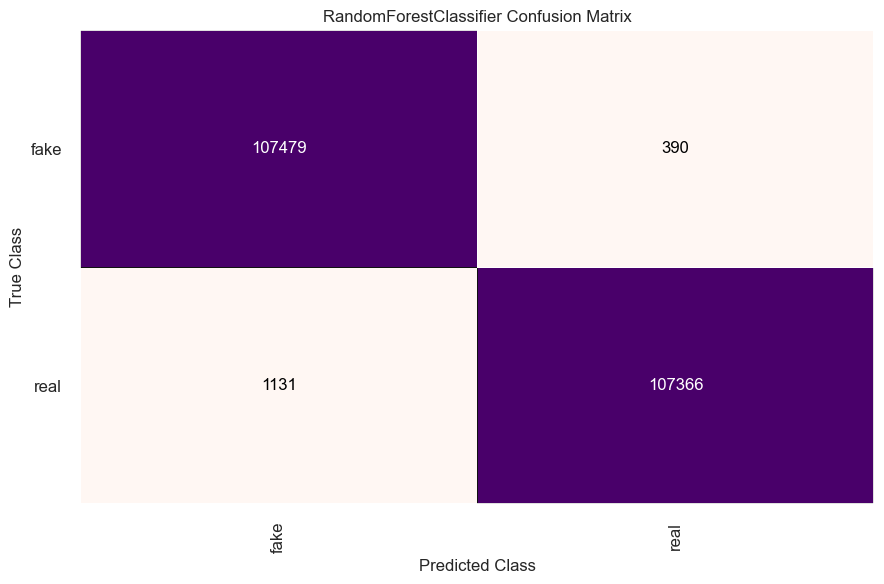

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [33]:
cm = ConfusionMatrix(rfc, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

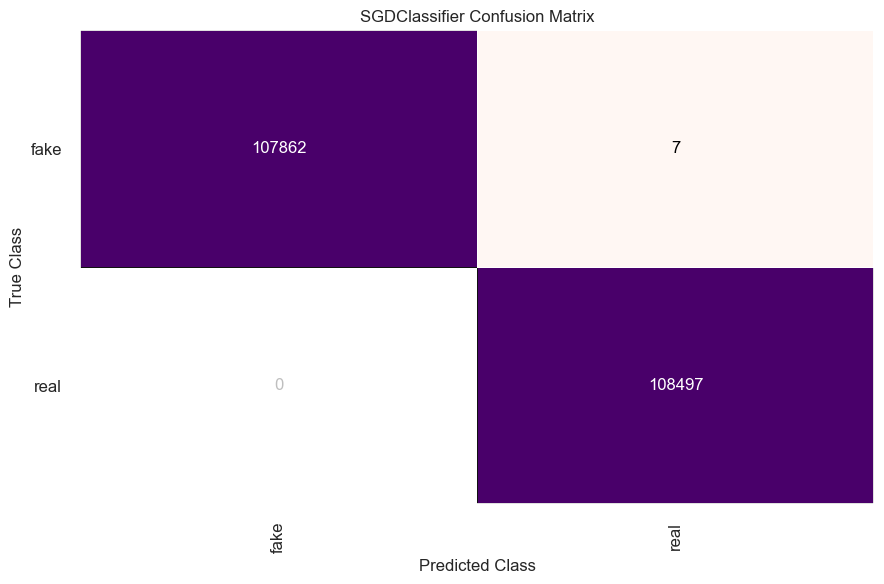

<AxesSubplot:title={'center':'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [34]:
cm = ConfusionMatrix(sgdc, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

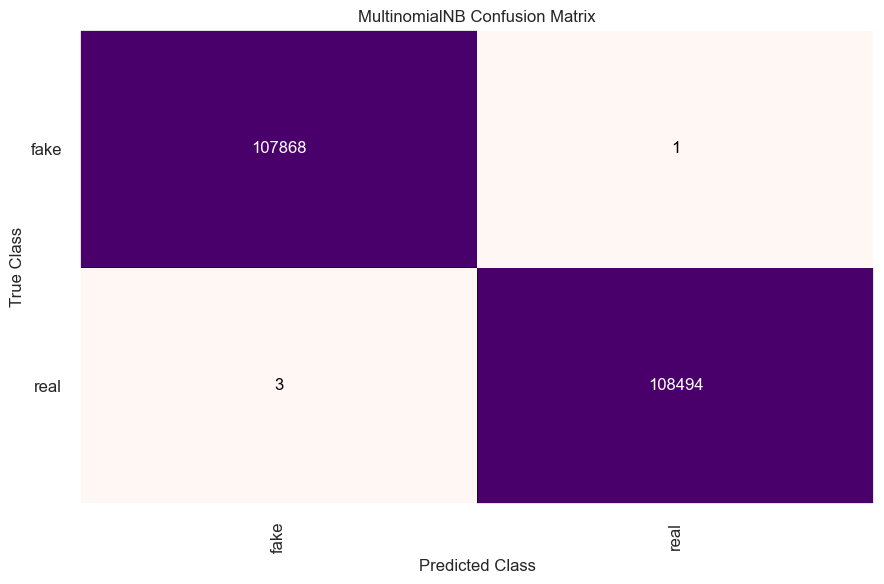

<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [35]:
cm = ConfusionMatrix(mnb, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Classfication report

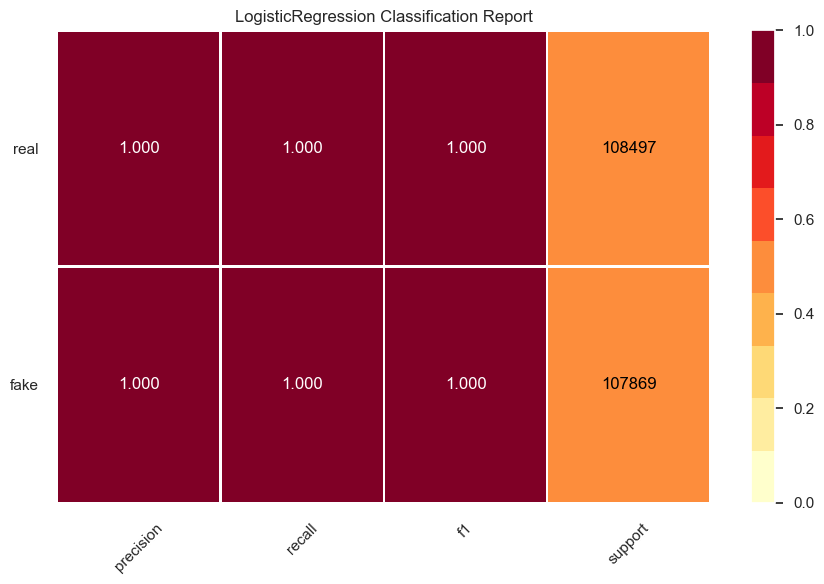

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [36]:
cr = ClassificationReport(logreg, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

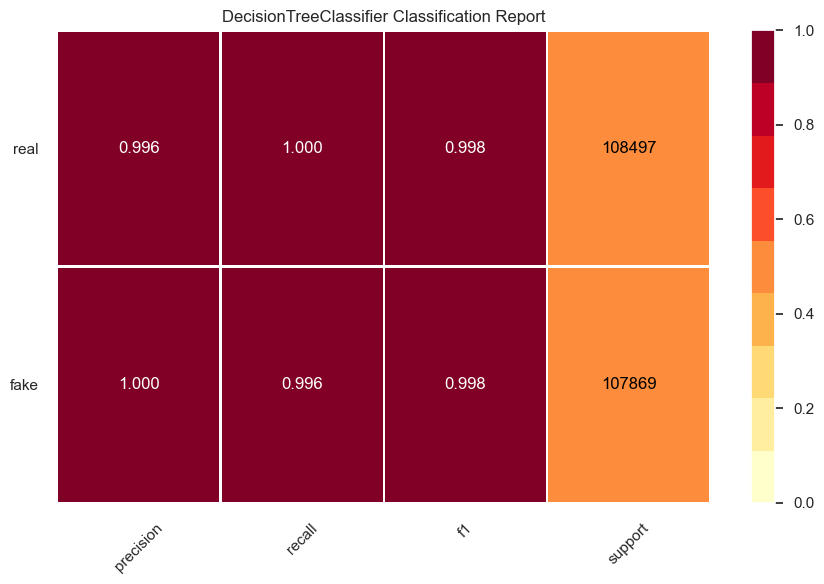

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [37]:
cr = ClassificationReport(dtc, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

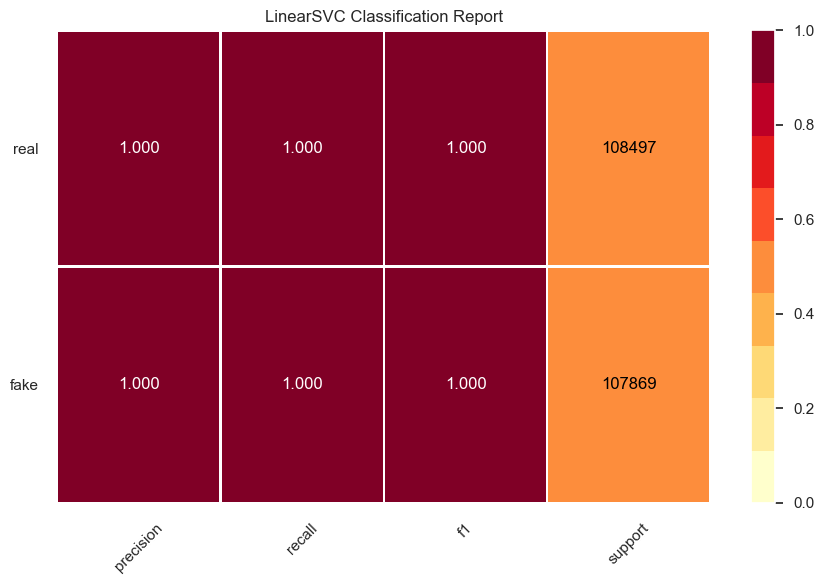

<AxesSubplot:title={'center':'LinearSVC Classification Report'}>

In [38]:
cr = ClassificationReport(lsvc, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

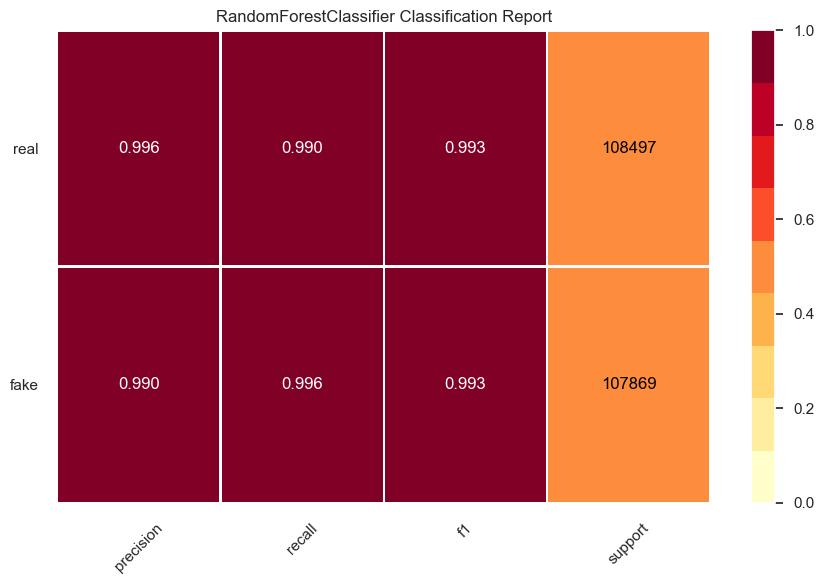

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [39]:
cr = ClassificationReport(rfc, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

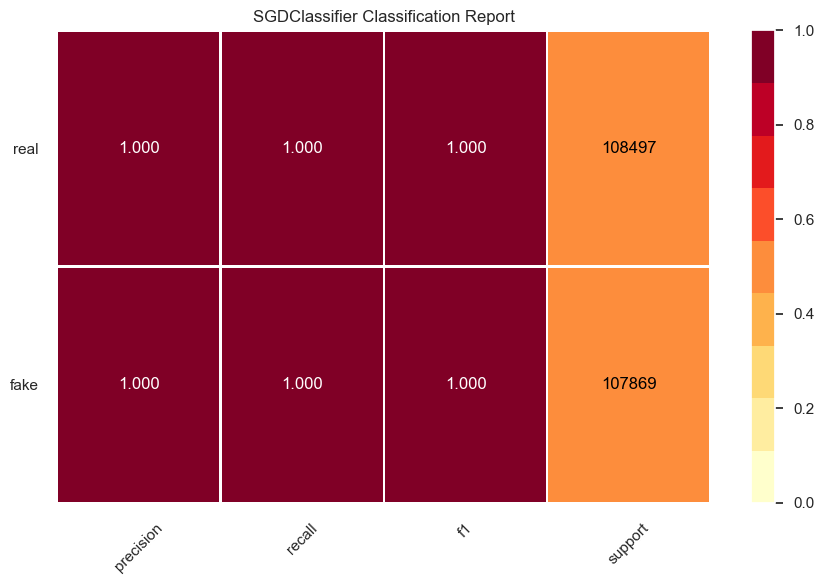

<AxesSubplot:title={'center':'SGDClassifier Classification Report'}>

In [40]:
cr = ClassificationReport(sgdc, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

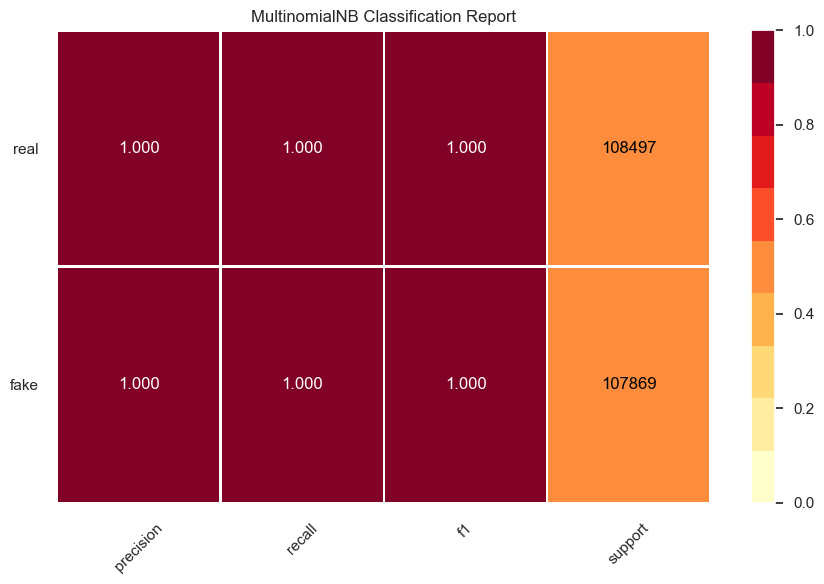

<AxesSubplot:title={'center':'MultinomialNB Classification Report'}>

In [41]:
cr = ClassificationReport(mnb, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

### Class prediction error

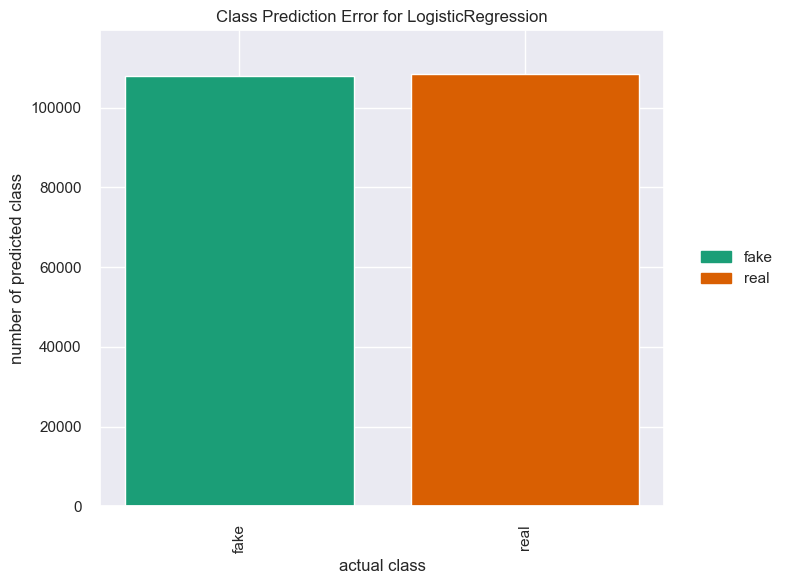

<AxesSubplot:title={'center':'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [42]:
cpe = ClassPredictionError(logreg, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

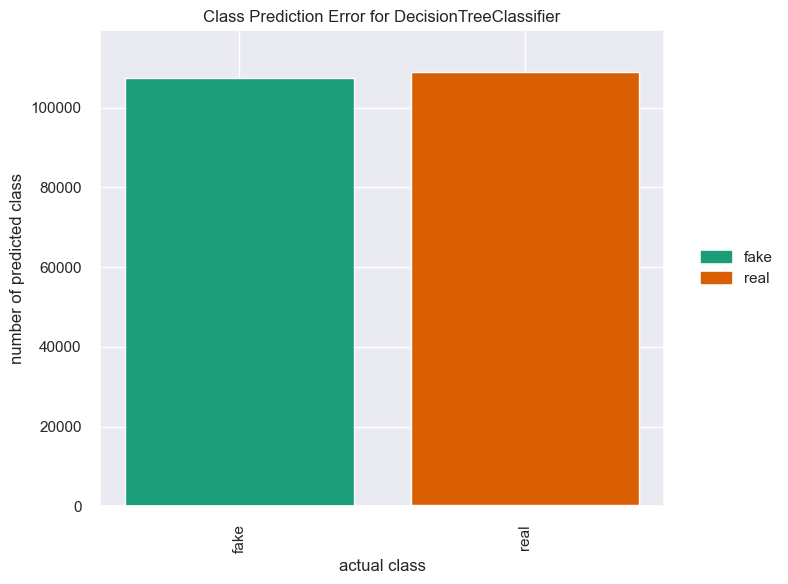

<AxesSubplot:title={'center':'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [43]:
cpe = ClassPredictionError(dtc, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

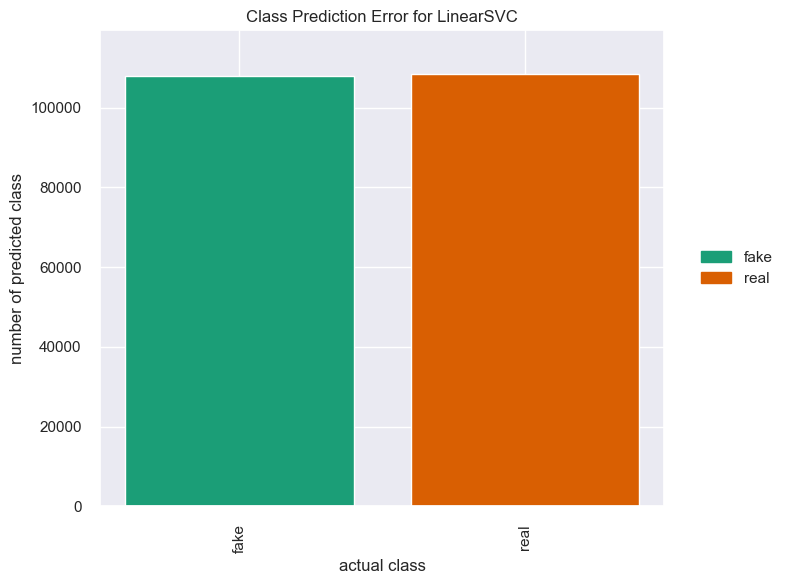

<AxesSubplot:title={'center':'Class Prediction Error for LinearSVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [44]:
cpe = ClassPredictionError(lsvc, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

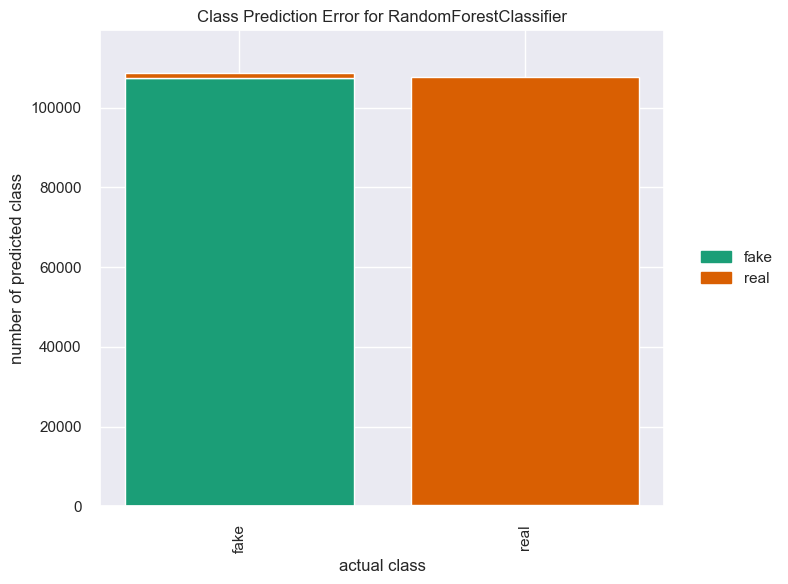

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [45]:
cpe = ClassPredictionError(rfc, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

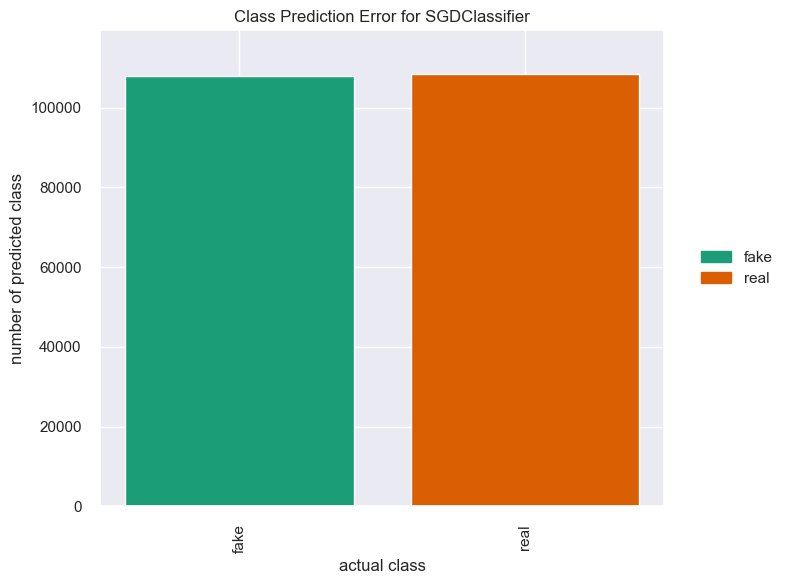

<AxesSubplot:title={'center':'Class Prediction Error for SGDClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [46]:
cpe = ClassPredictionError(sgdc, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

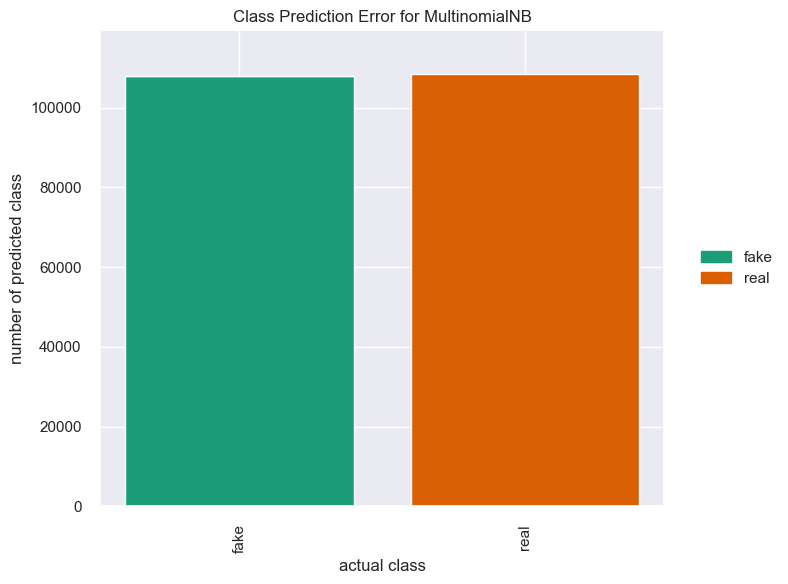

<AxesSubplot:title={'center':'Class Prediction Error for MultinomialNB'}, xlabel='actual class', ylabel='number of predicted class'>

In [47]:
cpe = ClassPredictionError(mnb, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()

### ROCAUC

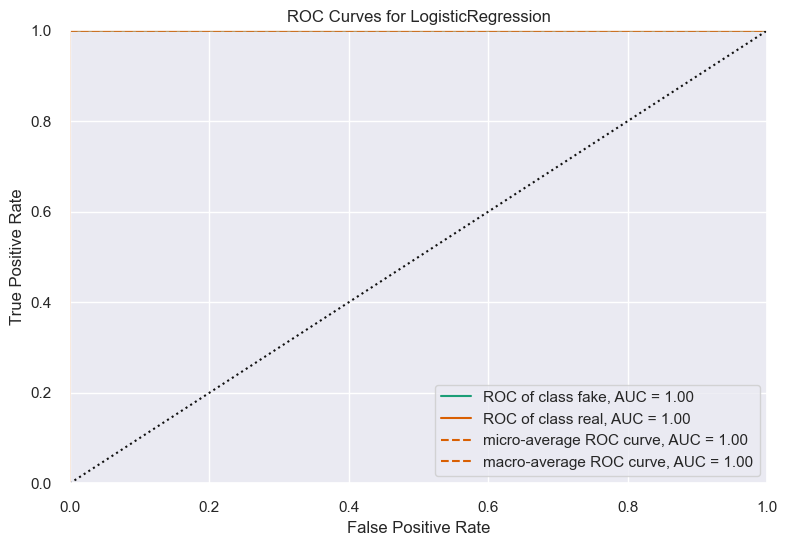

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
rocauc = ROCAUC(logreg, classes=classes)
rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

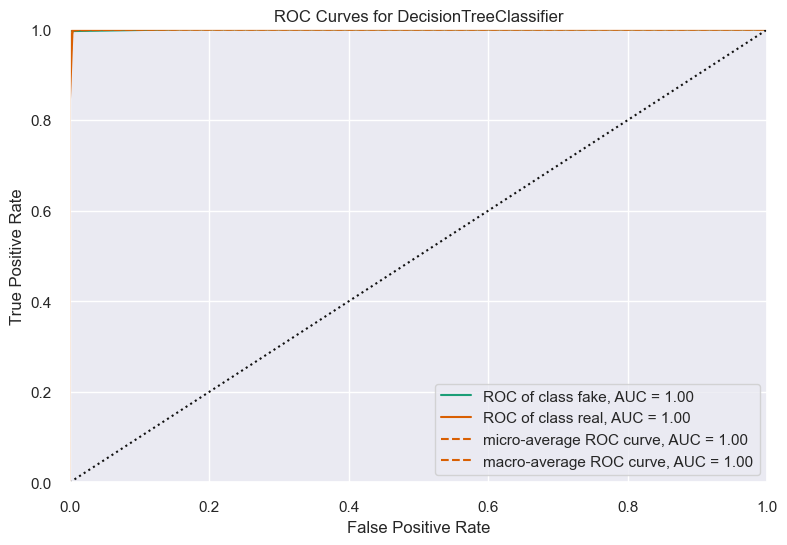

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [49]:
rocauc = ROCAUC(dtc, classes=classes)
rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

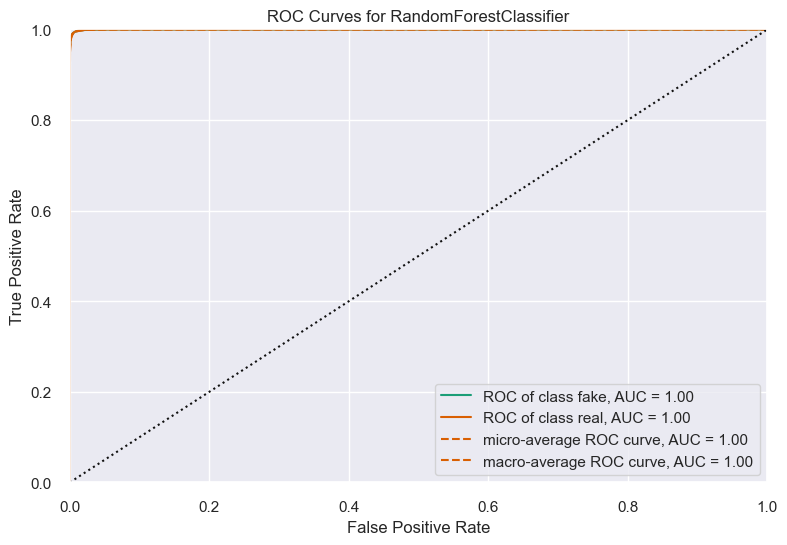

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
rocauc = ROCAUC(rfc, classes=classes)
rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

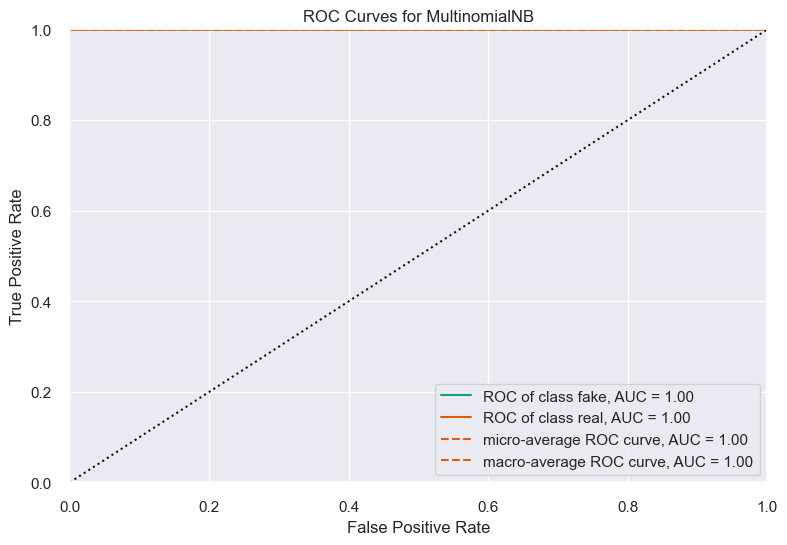

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [51]:
rocauc = ROCAUC(mnb, classes=classes)
rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

### Precision recall curve

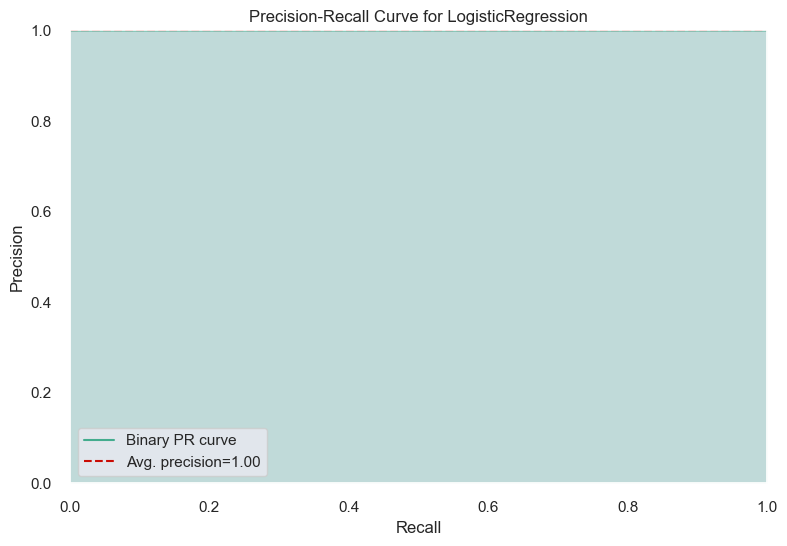

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [52]:
prc = PrecisionRecallCurve(logreg)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

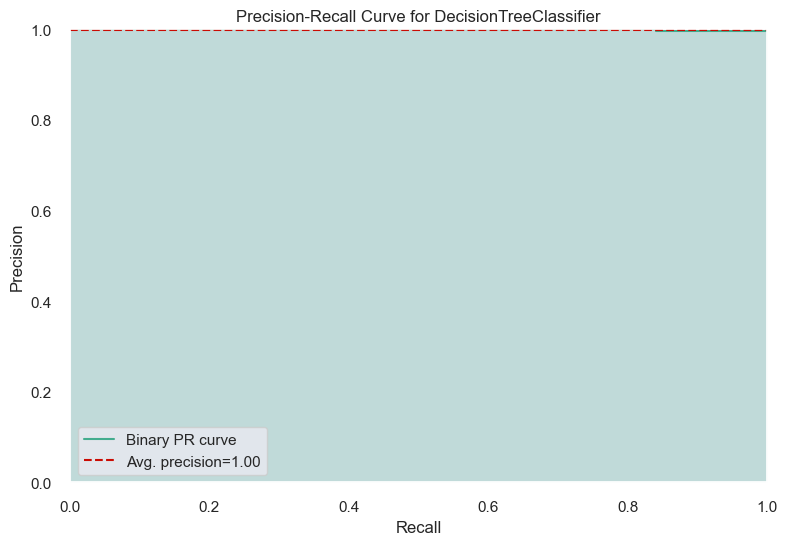

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [53]:
prc = PrecisionRecallCurve(dtc)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

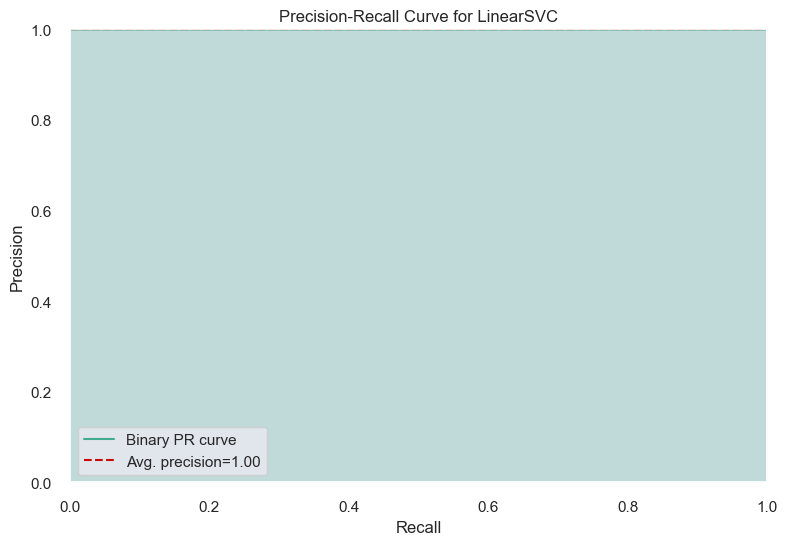

<AxesSubplot:title={'center':'Precision-Recall Curve for LinearSVC'}, xlabel='Recall', ylabel='Precision'>

In [54]:
prc = PrecisionRecallCurve(lsvc)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

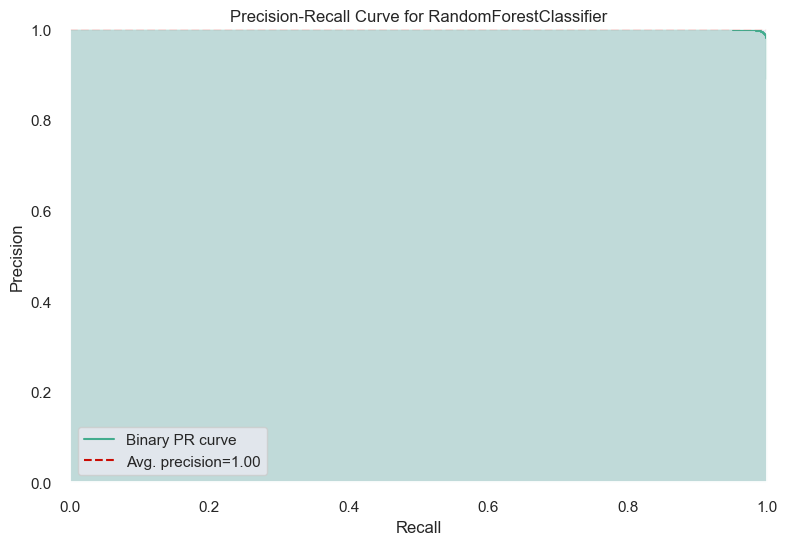

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [55]:
prc = PrecisionRecallCurve(rfc)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

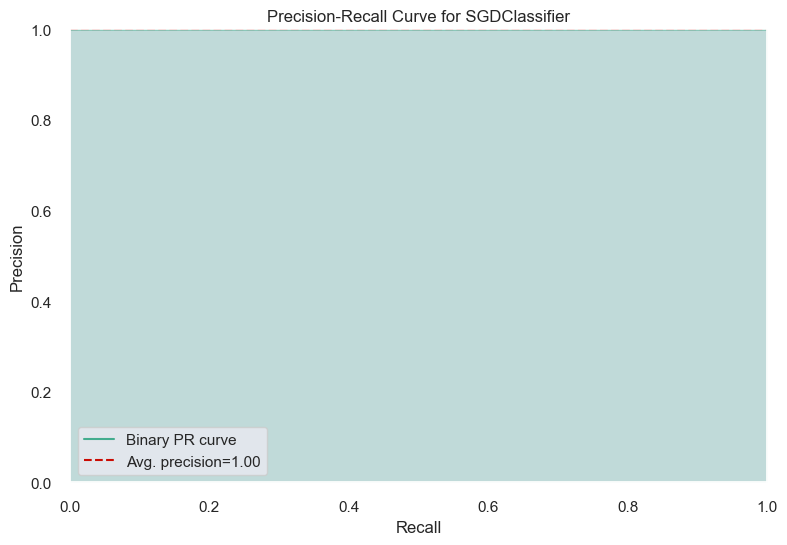

<AxesSubplot:title={'center':'Precision-Recall Curve for SGDClassifier'}, xlabel='Recall', ylabel='Precision'>

In [56]:
prc = PrecisionRecallCurve(sgdc)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

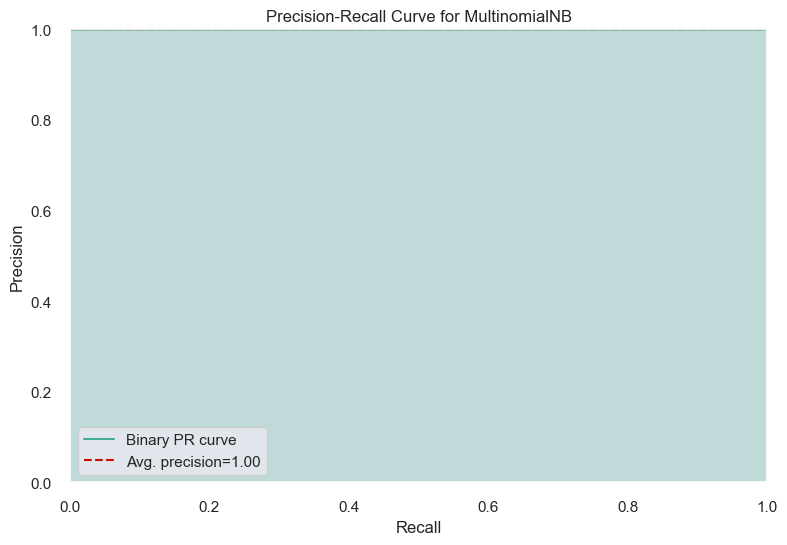

<AxesSubplot:title={'center':'Precision-Recall Curve for MultinomialNB'}, xlabel='Recall', ylabel='Precision'>

In [57]:
prc = PrecisionRecallCurve(mnb)
prc.fit(X_train, y_train)
prc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc.show()

### Validation curve

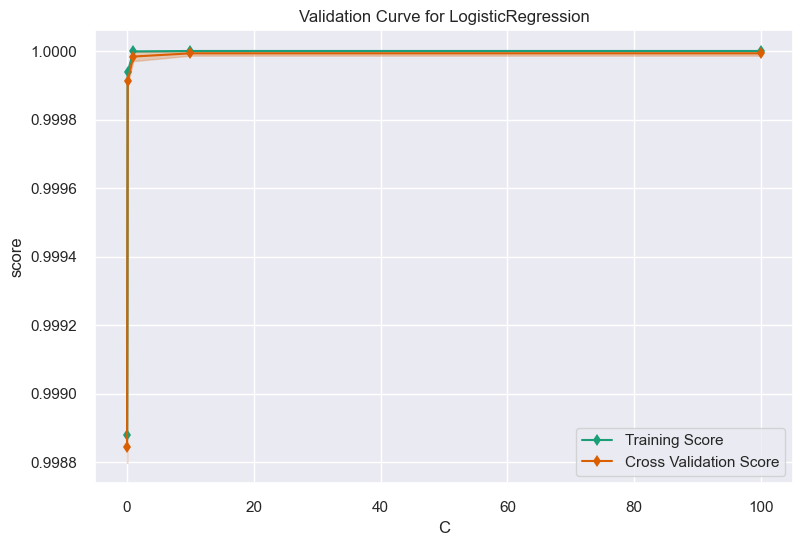

<AxesSubplot:title={'center':'Validation Curve for LogisticRegression'}, xlabel='C', ylabel='score'>

In [58]:
param_range = [0.01,0.1,1.0,10,100]
viz = ValidationCurve(
    LogisticRegression(random_state=seed), param_name="C",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

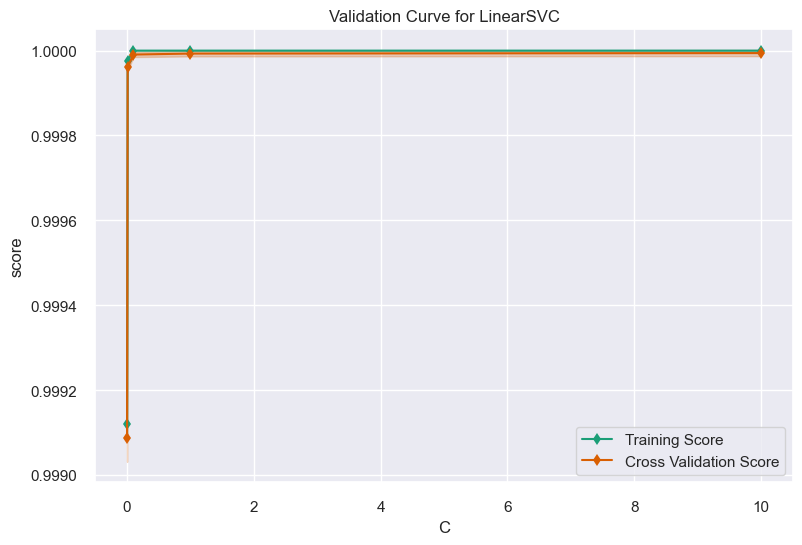

<AxesSubplot:title={'center':'Validation Curve for LinearSVC'}, xlabel='C', ylabel='score'>

In [59]:
param_range = [0.001,0.01,0.1,1.0,10]
viz = ValidationCurve(
    LinearSVC(dual=False, random_state=seed), param_name="C",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

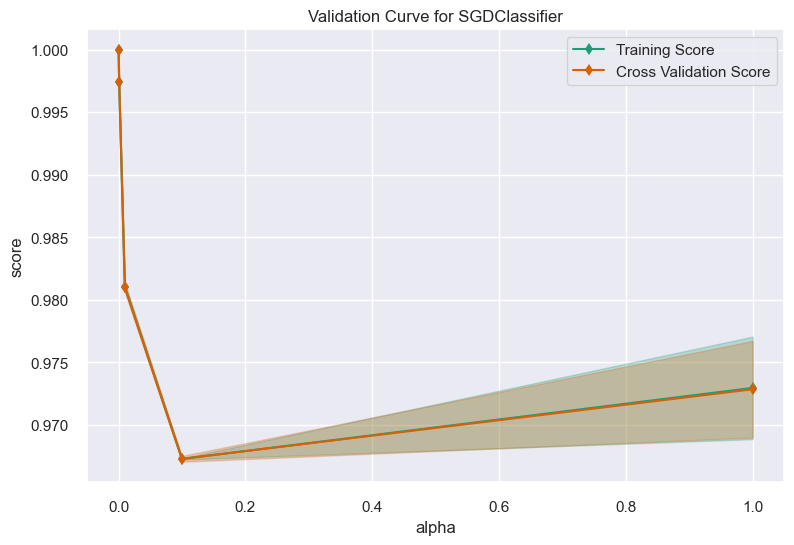

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='alpha', ylabel='score'>

In [60]:
param_range = [0.0001,0.001,0.01,0.1,1.0]
viz = ValidationCurve(
    SGDClassifier(max_iter=1500,random_state=seed), param_name="alpha",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

## Decision regions Vizualizer from mlextend

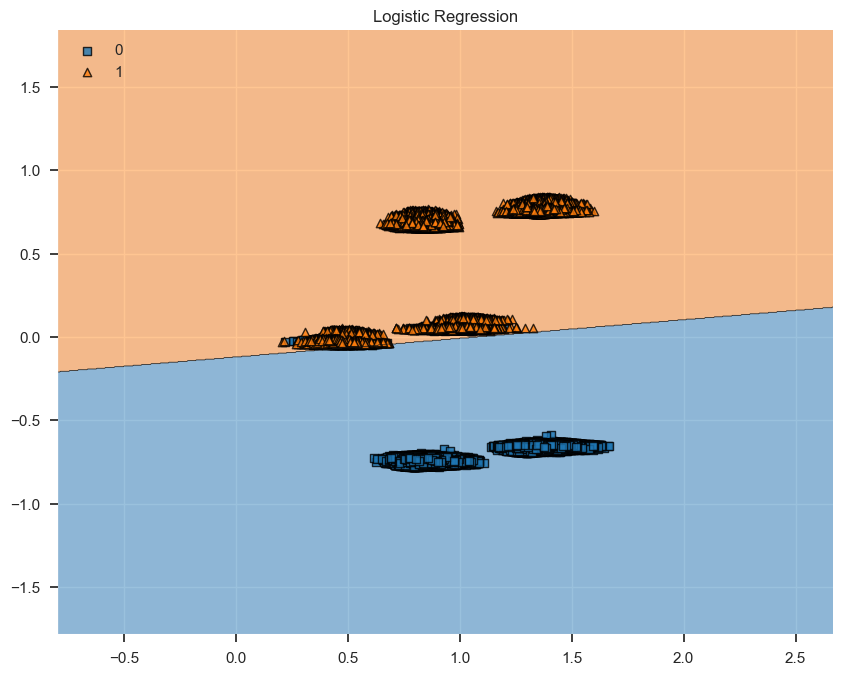

In [61]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

logreg.fit(X, y)
fig = plot_decision_regions(X=X, y=y, clf=logreg, legend=2)
plt.title('Logistic Regression')

plt.show()

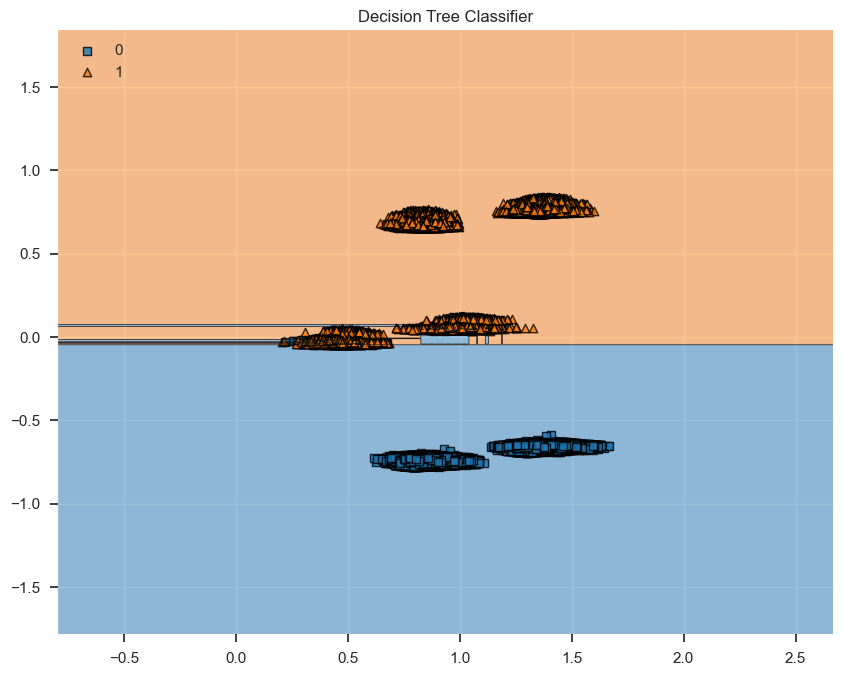

In [62]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

dtc.fit(X, y)
fig = plot_decision_regions(X=X, y=y, clf=dtc, legend=2)
plt.title('Decision Tree Classifier')

plt.show()

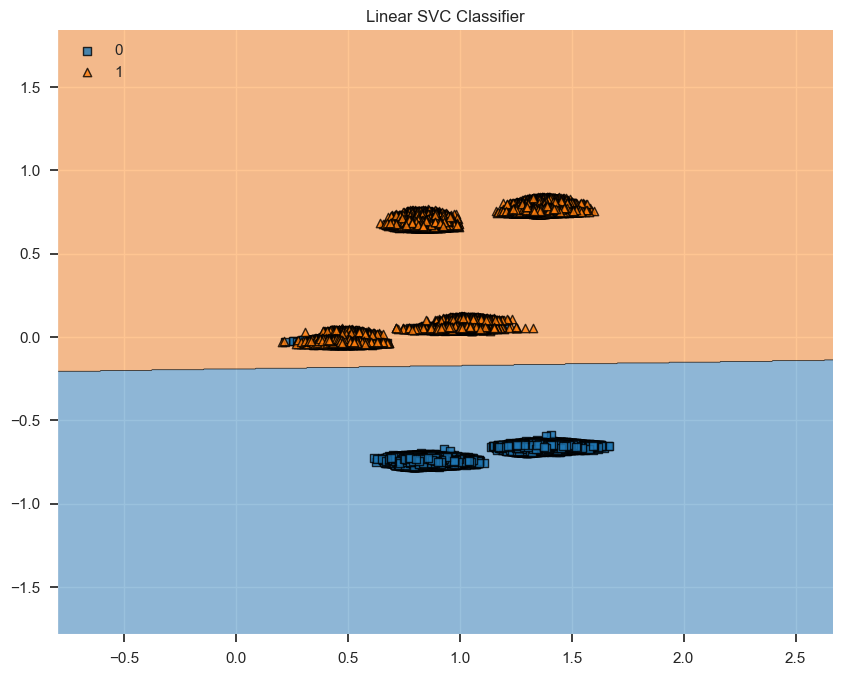

In [63]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

lsvc.fit(X, y)
fig = plot_decision_regions(X=X, y=y, clf=lsvc, legend=2)
plt.title('Linear SVC Classifier')

plt.show()

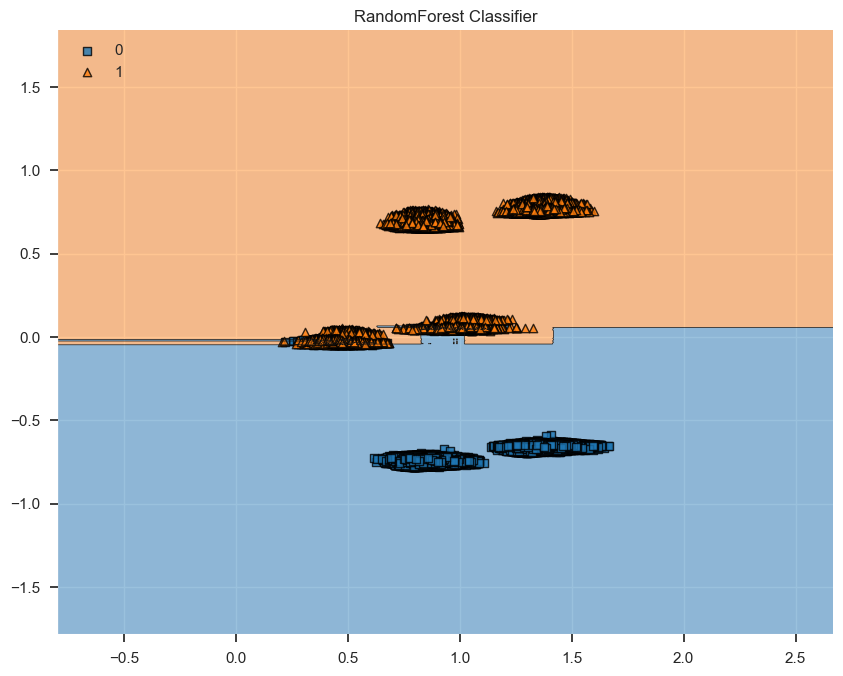

In [64]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

rfc.fit(X, y)
fig = plot_decision_regions(X=X, y=y, clf=rfc, legend=2)
plt.title('RandomForest Classifier')

plt.show()

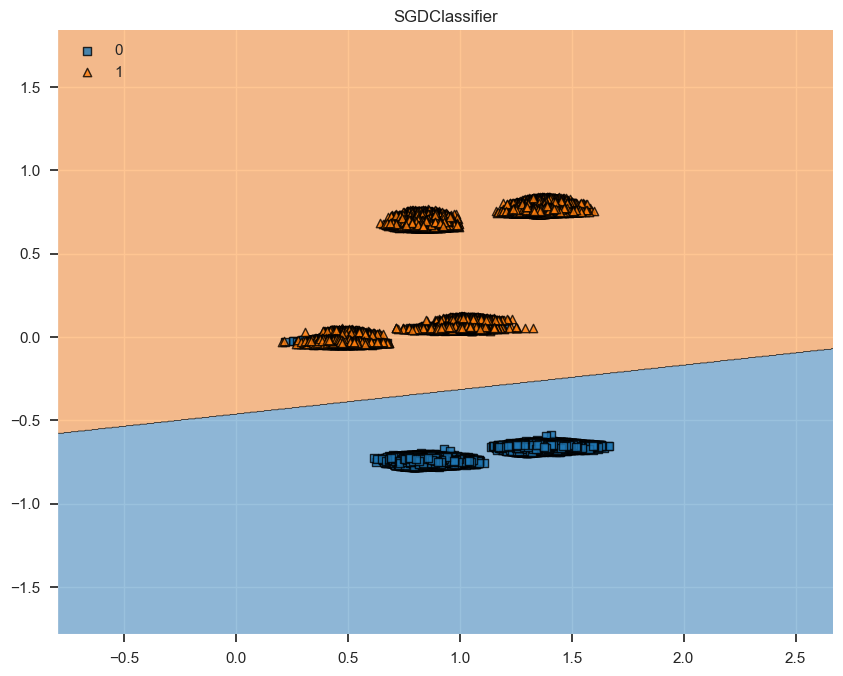

In [65]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

sgdc.fit(X, y)
fig = plot_decision_regions(X=X, y=y, clf=sgdc, legend=2)
plt.title('SGDClassifier')

plt.show()

## Ensemble Meta-classifier

**This is to determine the best classifier**

In [66]:
from mlxtend.classifier import EnsembleVoteClassifier

In [67]:
clf1 = LogisticRegression(random_state=seed)
clf2 = DecisionTreeClassifier(criterion = 'gini', max_depth= 20, splitter='best', random_state=seed)
clf3 = LinearSVC(C=0.01, dual=False, random_state=seed)
clf4 = SGDClassifier(max_iter=1500,random_state=seed)
clf5 = MultinomialNB()

In [68]:
#Initiate the ensemble classifier
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3,clf4,clf5], weights=[1,1,1,1,1],voting='hard', verbose=1)

#Fit the model
eclf.fit(X_train,y_train)

Fitting 5 classifiers...
Fitting clf1: logisticregression (1/5)
Fitting clf2: decisiontreeclassifier (2/5)
Fitting clf3: linearsvc (3/5)
Fitting clf4: sgdclassifier (4/5)
Fitting clf5: multinomialnb (5/5)


EnsembleVoteClassifier(clfs=[LogisticRegression(random_state=123),
                             DecisionTreeClassifier(max_depth=20,
                                                    random_state=123),
                             LinearSVC(C=0.01, dual=False, random_state=123),
                             SGDClassifier(max_iter=1500, random_state=123),
                             MultinomialNB()],
                       verbose=1, weights=[1, 1, 1, 1, 1])

In [69]:
#Predict the Test using the fitted model
y_pred_eclf = eclf.predict(X_test)

## Evaluations and performance

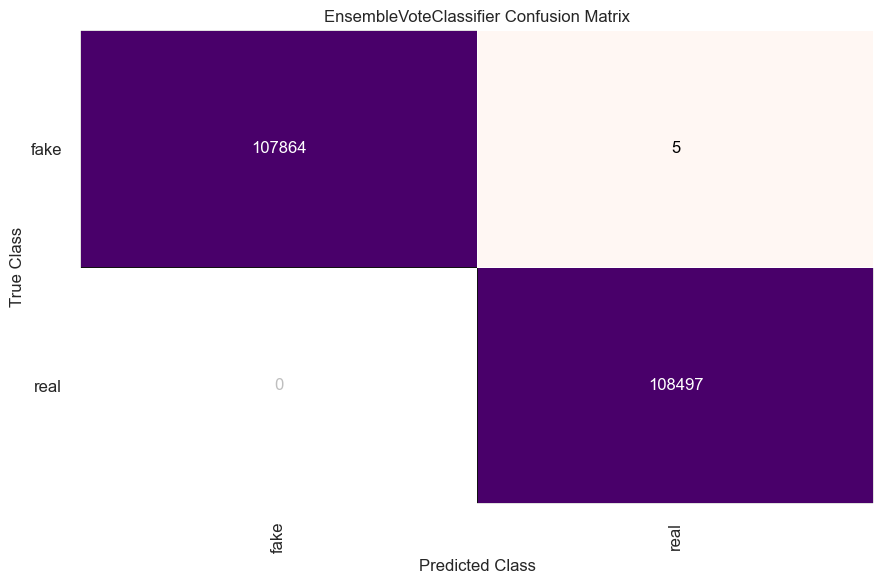

<AxesSubplot:title={'center':'EnsembleVoteClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [70]:
#confusion matrix
cm = ConfusionMatrix(eclf, classes=classes, cmap='RdPu')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

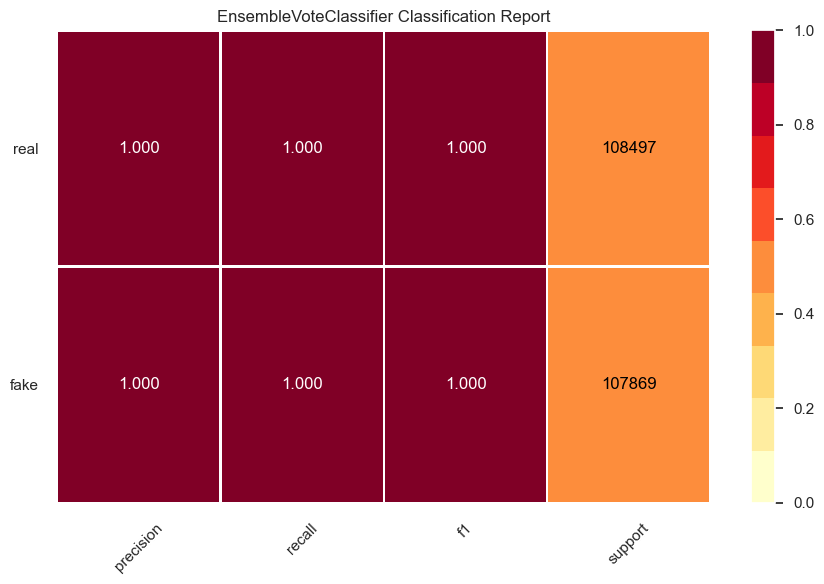

<AxesSubplot:title={'center':'EnsembleVoteClassifier Classification Report'}>

In [71]:
#Classification report
cr = ClassificationReport(eclf, classes=classes, support=True)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.show()

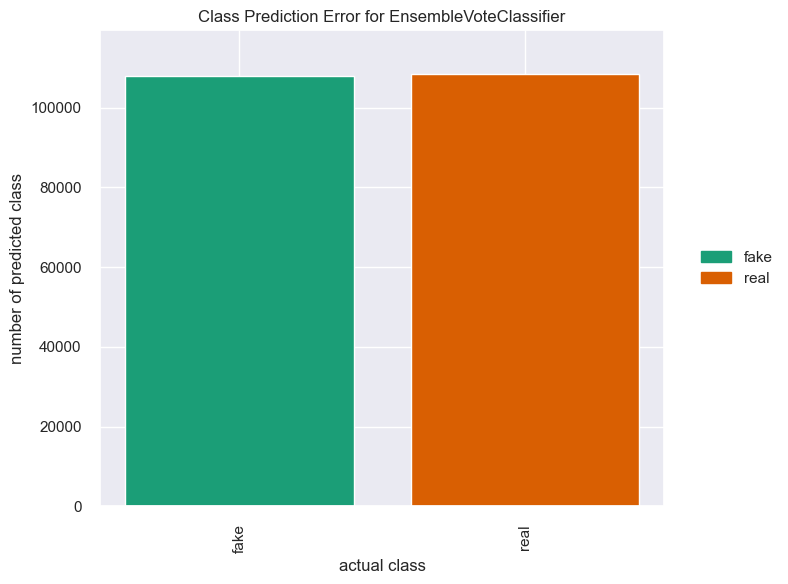

<AxesSubplot:title={'center':'Class Prediction Error for EnsembleVoteClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [72]:
#Class prediction error
cpe = ClassPredictionError(eclf, classes=classes)
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show()